# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.omf import Borehole3D, striplog_legend_to_omf_legend 
from utils.io import boreholes_from_files, striplog_from_text,gdf_viewer,\
df_from_sources, striplog_from_df
from core.core import Project
from core.orm import BoreholeOrm, PositionOrm, Base 

import matplotlib.pyplot as plt
from os import remove
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
search_dir=ROOT_DIR+'/CF_data/synthese/Result_traitem/'
cols=['ID','X','Y','Z','Long_Pz','Diam_Pz_int']
filename='source_Boreholes'

In [3]:
df_all=df_from_sources(search_dir, filename, cols, verbose=False)

--> base_Memoris3/source_Boreholes.csv: (148 lines)
--> profils_sols_donnees_forages/source_Boreholes.csv: (42 lines)

The overall dataframe contains 190 lines. 2 files used


## Data Checking

In [4]:
gdf_viewer(df_all)

Rows : 190, columns : 7


interactive(children=(IntSlider(value=10, description='rows', max=190, min=10, readout=False), IntSlider(value…

In [5]:
dist_crit=1

indexes = []
for i in range(0,len(df_all)-1):
    d=df_all.loc[i, 'geometry'].distance(df_all.loc[i+1, 'geometry'])
    if d<dist_crit or d>1e+4:
        indexes.append(i)
        #print(f"{df_all.loc[i,'ID']} <-> {df_all.loc[i+1,'ID']} : {d:.2} meters")
print('\n',f'{len(indexes)}/{len(df_all)} elements with probably bad XY')
print(f'\nIndexes: {indexes}\n\nNAN_indexes: {df_all.query("X!=X").index}')


 29/190 elements with probably bad XY

Indexes: [49, 66, 69, 71, 74, 76, 78, 115, 120, 121, 123, 166, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]

NAN_indexes: Int64Index([173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
            186, 187, 188, 189],
           dtype='int64')


In [6]:
df_all.drop(index=df_all.query("X!=X").index, inplace=True)
df_all.reset_index(drop=True, inplace=True)
len(df_all)

173

## Create Boreholes from dataframes or files

In [7]:
bhs_df=[df_all]

In [8]:
boreholes, components= boreholes_from_files(bhs_df, verbose=True, 
                                            diam_field='Diam_Pz_int', 
                                            length_field='Long_Pz')


Dataframe 0 processing...
length=6.94
|__ID:'1' -- No lithology data, treated with default ('white sand')
{0: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f226f790>, 'base': <core.orm.PositionOrm object at 0x7f42f223d3a0>}}

length=3.27
|__ID:'12' -- No lithology data, treated with default ('white sand')
{1: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f22c8910>, 'base': <core.orm.PositionOrm object at 0x7f42f22c8d30>}}

length=6.04
|__ID:'22' -- No lithology data, treated with default ('white sand')
{2: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f23899d0>, 'base': <core.orm.PositionOrm object at 0x7f42f223deb0>}}

length=6.51
|__ID:'25' -- No lithology data, treated with default ('white sand')
{3: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f22f2040>, 'base': <core.orm.Positio

length=3.27
|__ID:'175' -- No lithology data, treated with default ('white sand')
{35: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f2206490>, 'base': <core.orm.PositionOrm object at 0x7f42f21ed400>}}

length=6.54
|__ID:'180' -- No lithology data, treated with default ('white sand')
{36: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f220efa0>, 'base': <core.orm.PositionOrm object at 0x7f42f220eee0>}}

length=9.05
|__ID:'186' -- No lithology data, treated with default ('white sand')
{37: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f220e070>, 'base': <core.orm.PositionOrm object at 0x7f42f220ef40>}}

length=8.54
|__ID:'197' -- No lithology data, treated with default ('white sand')
{38: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f220ebe0>, 'base': <core.orm.PositionOrm object at 0x7

|__ID:'MW01' -- No length provided, treated with default (length=3.0)
|__ID:'MW01' -- No lithology data, treated with default ('white sand')
{81: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f21e1b80>, 'base': <core.orm.PositionOrm object at 0x7f42f21d8be0>}}

|__ID:'Silo' -- No length provided, treated with default (length=3.0)
|__ID:'Silo' -- No lithology data, treated with default ('white sand')
{82: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f2168f10>, 'base': <core.orm.PositionOrm object at 0x7f42f2168610>}}

|__ID:'Thiriau' -- No length provided, treated with default (length=3.0)
|__ID:'Thiriau' -- No lithology data, treated with default ('white sand')
{83: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f2168640>, 'base': <core.orm.PositionOrm object at 0x7f42f2168d60>}}

length=9.69
|__ID:'501' -- No lithology data, treated w

|__ID:'DRAIN 6' -- No length provided, treated with default (length=3.0)
|__ID:'DRAIN 6' -- No lithology data, treated with default ('white sand')
{134: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f214aa30>, 'base': <core.orm.PositionOrm object at 0x7f42f214ad00>}}

|__ID:'DRAIN 7' -- No length provided, treated with default (length=3.0)
|__ID:'DRAIN 7' -- No lithology data, treated with default ('white sand')
{135: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f2154b20>, 'base': <core.orm.PositionOrm object at 0x7f42f2154d60>}}

|__ID:'DRAIN 7b' -- No length provided, treated with default (length=3.0)
|__ID:'DRAIN 7b' -- No lithology data, treated with default ('white sand')
{136: {'description': 'white sand', 'interval_number': 0, 'top': <core.orm.PositionOrm object at 0x7f42f214a070>, 'base': <core.orm.PositionOrm object at 0x7f42f214a730>}}

|__ID:'DRAIN 8' -- No length provided,

In [9]:
boreholes

[<core.orm.BoreholeOrm>(id=1, length=6.941000000000004, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=12, length=3.271000000000001, diameter=0.041, intervals=1),
 <core.orm.BoreholeOrm>(id=22, length=6.043000000000006, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=25, length=6.511999999999992, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=32, length=6.729999999999995, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=34, length=6.711999999999998, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=44, length=6.636000000000009, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=58, length=4.343000000000004, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=59, length=6.943999999999994, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=64, length=6.797000000000009, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=65, length=6.625000000000004, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=67, length=6.8859

In [10]:
len(boreholes), len(components)

(173, 1)

## Display the striplog and 3D view

### Display project boreholes

In [11]:
remove('tmp_files/tfe_orm_db.db')

In [12]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [13]:
Base.metadata.create_all(engine)

2021-04-01 05:13:53,132 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-04-01 05:13:53,133 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:53,134 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-04-01 05:13:53,135 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:53,137 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Boreholes")
2021-04-01 05:13:53,138 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:53,138 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Boreholes")
2021-04-01 05:13:53,139 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:53,139 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Positions")
2021-04-01 05:13:53,140 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:53,140 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Positions")
2021-04-01 05:13:53,141 INFO sqlalchemy.engine.base.Engine ()
2021-04-01

In [14]:
Session = sessionmaker(bind=engine)
session = Session()

In [15]:
p = Project(session)
p.add_components(components)

2021-04-01 05:13:53,184 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:53,185 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:53,186 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:53,188 INFO sqlalchemy.engine.base.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-04-01 05:13:53,188 INFO sqlalchemy.engine.base.Engine (0, 'Sand, white')
2021-04-01 05:13:53,189 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:53,192 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:53,193 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:53,194 INFO sqlalchemy.engine.base.Engine ()


Add boreholes into the project

In [16]:
for bh in boreholes:
    p.add_borehole(bh)

2021-04-01 05:13:53,201 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:53,202 INFO sqlalchemy.engine.base.Engine ('1', 6.941000000000004, 0.025)
2021-04-01 05:13:53,204 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:53,204 INFO sqlalchemy.engine.base.Engine ((0, 0.0, 0.0, 0.0, 153124.071, 122653.382), (1, 6.941000000000004, 6.941000000000004, 6.941000000000004, 153124.071, 122653.382))
2021-04-01 05:13:53,207 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:53,208 INFO sqlalchemy.engine.base.Engine (0, '1', 0, 'white sand', 0, 1)
2021-04-01 05:13:53,210 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:53,213 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:53,214 INFO sqlalchemy.engine.bas

2021-04-01 05:13:53,384 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:53,384 INFO sqlalchemy.engine.base.Engine (3, '25', 0, 'white sand', 6, 7)
2021-04-01 05:13:53,385 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:53,389 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:53,389 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:53,390 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:53,392 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Inte

2021-04-01 05:13:53,558 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:53,559 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:13:53,559 INFO sqlalchemy.engine.base.Engine ('44',)
2021-04-01 05:13:53,561 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:53,561 INFO sqlalchemy.engine.base.Engine (12,)
2021-04-01 05:13:53,562 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS 

2021-04-01 05:13:53,789 INFO sqlalchemy.engine.base.Engine ('64',)
2021-04-01 05:13:53,790 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:53,791 INFO sqlalchemy.engine.base.Engine (18,)
2021-04-01 05:13:53,792 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:53,793 INFO sqlalchemy.engine.base.Engine (19,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:53,829 INFO sqlalch

2021-04-01 05:13:53,958 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:53,959 INFO sqlalchemy.engine.base.Engine (25,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:53,994 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:53,995 INFO sqlalchemy.engine.base.Engine ('80', 5.060000000000001, 0.025)
2021-04-01 05:13:53,996 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:53,997 INFO sqlalchemy.engine.base.Engine ((26, 0.0, 0.0, 0.0, 152881.955, 122572.824), (27, 5.060000000000001, 5.060000000

Borehole geometry created successfully !
2021-04-01 05:13:54,151 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:54,152 INFO sqlalchemy.engine.base.Engine ((32, 0.0, 0.0, 0.0, 152690.678, 122676.516), (33, 6.6960000000000015, 6.6960000000000015, 6.6960000000000015, 152690.678, 122676.516))
2021-04-01 05:13:54,154 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:54,155 INFO sqlalchemy.engine.base.Engine ('91', 6.6960000000000015, 0.025)
2021-04-01 05:13:54,157 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:54,157 INFO sqlalchemy.engine.base.Engine (16, '91', 0, 'white sand', 32, 33)
2021-04-01 05:13:54,159 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:54,162 INFO sqlalchemy.engine.base.Engine BEGIN (implicit

2021-04-01 05:13:54,316 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:54,316 INFO sqlalchemy.engine.base.Engine (19, '107', 0, 'white sand', 38, 39)
2021-04-01 05:13:54,317 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:54,320 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:54,321 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:54,322 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:54,323 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "

2021-04-01 05:13:54,481 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:54,482 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:13:54,483 INFO sqlalchemy.engine.base.Engine ('112',)
2021-04-01 05:13:54,484 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:54,484 INFO sqlalchemy.engine.base.Engine (44,)
2021-04-01 05:13:54,486 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS

2021-04-01 05:13:54,640 INFO sqlalchemy.engine.base.Engine ('142',)
2021-04-01 05:13:54,641 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:54,642 INFO sqlalchemy.engine.base.Engine (50,)
2021-04-01 05:13:54,644 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:54,644 INFO sqlalchemy.engine.base.Engine (51,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:54,681 INFO sqlalc

2021-04-01 05:13:54,805 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:54,806 INFO sqlalchemy.engine.base.Engine (57,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:54,844 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:54,845 INFO sqlalchemy.engine.base.Engine ((58, 0.0, 0.0, 0.0, 152380.767, 122789.492), (59, 4.394000000000005, 4.394000000000005, 4.394000000000005, 152380.767, 122789.492))
2021-04-01 05:13:54,846 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:54,846 INFO sqlalchemy.

2021-04-01 05:13:55,006 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:55,007 INFO sqlalchemy.engine.base.Engine ('168', 3.489999999999997, 0.041)
2021-04-01 05:13:55,009 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:55,010 INFO sqlalchemy.engine.base.Engine ((64, 0.0, 0.0, 0.0, 152392.567, 122777.004), (65, 3.489999999999997, 3.489999999999997, 3.489999999999997, 152392.567, 122777.004))
2021-04-01 05:13:55,012 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:55,012 INFO sqlalchemy.engine.base.Engine (32, '168', 0, 'white sand', 64, 65)
2021-04-01 05:13:55,014 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:55,018 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:55,019 INFO sqlalchemy.e

2021-04-01 05:13:55,175 INFO sqlalchemy.engine.base.Engine ('175', 3.2699999999999987, 0.041)
2021-04-01 05:13:55,176 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:55,177 INFO sqlalchemy.engine.base.Engine (35, '175', 0, 'white sand', 70, 71)
2021-04-01 05:13:55,178 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:55,181 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:55,182 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:55,183 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:55,184 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description 

2021-04-01 05:13:55,340 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:55,340 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:55,343 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:13:55,343 INFO sqlalchemy.engine.base.Engine ('197',)
2021-04-01 05:13:55,345 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "

2021-04-01 05:13:55,501 INFO sqlalchemy.engine.base.Engine ('400',)
2021-04-01 05:13:55,502 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:55,503 INFO sqlalchemy.engine.base.Engine (82,)
2021-04-01 05:13:55,504 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:55,505 INFO sqlalchemy.engine.base.Engine (83,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:55,543 INFO sqlalc

2021-04-01 05:13:55,664 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:55,665 INFO sqlalchemy.engine.base.Engine (89,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:55,701 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:55,702 INFO sqlalchemy.engine.base.Engine ((90, 0.0, 0.0, 0.0, 153094.7422, 122552.6908), (91, 2.640000000000001, 2.640000000000001, 2.640000000000001, 153094.7422, 122552.6908))
2021-04-01 05:13:55,703 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:55,704 INFO sqlalch

Borehole geometry created successfully !
2021-04-01 05:13:55,852 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:55,853 INFO sqlalchemy.engine.base.Engine ((96, 0.0, 0.0, 0.0, 152425.527, 122782.258), (97, 6.03, 6.03, 6.03, 152425.527, 122782.258))
2021-04-01 05:13:55,855 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:55,855 INFO sqlalchemy.engine.base.Engine ('143B', 6.03, 0.041)
2021-04-01 05:13:55,857 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:55,857 INFO sqlalchemy.engine.base.Engine (48, '143B', 0, 'white sand', 96, 97)
2021-04-01 05:13:55,859 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:55,862 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:55,863 INFO sqlalchemy.engine.bas

2021-04-01 05:13:56,013 INFO sqlalchemy.engine.base.Engine ((102, 0.0, 0.0, 0.0, 152340.06, 122848.539), (103, 5.926999999999998, 5.926999999999998, 5.926999999999998, 152340.06, 122848.539))
2021-04-01 05:13:56,014 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:56,015 INFO sqlalchemy.engine.base.Engine (51, '181B', 0, 'white sand', 102, 103)
2021-04-01 05:13:56,015 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:56,019 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:56,020 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:56,021 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:56,023 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Inte

2021-04-01 05:13:56,177 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:56,180 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:56,181 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:56,182 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:56,184 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:13:56,184 INFO sqlalchemy.engine.base.Engine ('205A',)
2021-04-01 05:13:56,186 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positio

2021-04-01 05:13:56,340 INFO sqlalchemy.engine.base.Engine ('48b',)
2021-04-01 05:13:56,341 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:56,342 INFO sqlalchemy.engine.base.Engine (114,)
2021-04-01 05:13:56,344 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:56,345 INFO sqlalchemy.engine.base.Engine (115,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:56,381 INFO sqla

2021-04-01 05:13:56,501 INFO sqlalchemy.engine.base.Engine (120,)
2021-04-01 05:13:56,502 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:56,502 INFO sqlalchemy.engine.base.Engine (121,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:56,536 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-04-01 05:13:56,537 INFO sqlalchemy.engine.base.Engine (3.0, 'Canal C')
2021-04-01 05:13:56,538 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:56,539 INFO sqlalchemy.engine.base.Engine ('Canal F', nan, nan)
2021-04-01 05:13:56,540 INFO sqlal

2021-04-01 05:13:56,661 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:56,661 INFO sqlalchemy.engine.base.Engine (127,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:56,698 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:56,699 INFO sqlalchemy.engine.base.Engine ((128, 0.0, 0.0, 0.0, 153049.921, 122636.217), (129, 3.366, 3.366, 3.366, 153049.921, 122636.217))
2021-04-01 05:13:56,700 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-04-01 05:13:56,700 INFO sqlalchemy.engine.base.Engine (3.0, 'MW02')
2021-04

2021-04-01 05:13:56,820 INFO sqlalchemy.engine.base.Engine (133,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:56,857 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:56,857 INFO sqlalchemy.engine.base.Engine ((134, 0.0, 0.0, 0.0, 153022.74, 122542.529), (135, 3.0, 3.0, 3.0, 153022.74, 122542.529))
2021-04-01 05:13:56,859 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-04-01 05:13:56,859 INFO sqlalchemy.engine.base.Engine (3.0, 'FP 49 PROF')
2021-04-01 05:13:56,860 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:56,861 INFO sqlalchemy.engine.base.Engine ('FP 49 SUP', nan, 0.041)
2021-04-01 05:13:56,862 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, to

No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:57,018 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:57,019 INFO sqlalchemy.engine.base.Engine ('FP117sup', 12.178000000000008, 0.025)
2021-04-01 05:13:57,021 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:57,021 INFO sqlalchemy.engine.base.Engine ((140, 0.0, 0.0, 0.0, 152751.033, 122781.402), (141, 12.178000000000008, 12.178000000000008, 12.178000000000008, 152751.033, 122781.402))
2021-04-01 05:13:57,022 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:57,023 INFO sqlalchemy.engine.base.Engine (70, 'FP117sup', 0, 'white sand', 140, 141)
2021-04-01 05:13:57,025 INFO sqlalchemy.engine.base.Engi

2021-04-01 05:13:57,184 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:57,185 INFO sqlalchemy.engine.base.Engine ('FP15', 19.227999999999994, 0.041)
2021-04-01 05:13:57,186 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:57,187 INFO sqlalchemy.engine.base.Engine (73, 'FP15', 0, 'white sand', 146, 147)
2021-04-01 05:13:57,188 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:57,193 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:57,194 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:57,194 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:57,197 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "In

2021-04-01 05:13:57,358 INFO sqlalchemy.engine.base.Engine (76, 'FP63 prof', 0, 'white sand', 152, 153)
2021-04-01 05:13:57,359 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:57,362 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:57,363 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:57,364 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:57,366 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:13:57,367 INFO sqlalchemy.engine.base.Engine ('FP63 prof',)
2021-04-01 05:13:57,

2021-04-01 05:13:57,531 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:13:57,532 INFO sqlalchemy.engine.base.Engine ('FP76 sup',)
2021-04-01 05:13:57,533 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:57,534 INFO sqlalchemy.engine.base.Engine (158,)
2021-04-01 05:13:57,535 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper",

2021-04-01 05:13:57,697 INFO sqlalchemy.engine.base.Engine ('Silo',)
2021-04-01 05:13:57,698 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:57,699 INFO sqlalchemy.engine.base.Engine (164,)
2021-04-01 05:13:57,700 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:57,701 INFO sqlalchemy.engine.base.Engine (165,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:57,735 INFO sql

2021-04-01 05:13:57,859 INFO sqlalchemy.engine.base.Engine (170,)
2021-04-01 05:13:57,860 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:57,861 INFO sqlalchemy.engine.base.Engine (171,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:57,896 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:57,896 INFO sqlalchemy.engine.base.Engine ((172, 0.0, 0.0, 0.0, 152320.64, 122857.13), (173, 5.439999999999999, 5.439999999999999, 5.439999999999999, 152320.64, 122857.13))
2021-04-01 05:13:57,898 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, di

No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:58,140 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:58,140 INFO sqlalchemy.engine.base.Engine ((178, 0.0, 0.0, 0.0, 152387.87, 122847.84), (179, 4.780000000000001, 4.780000000000001, 4.780000000000001, 152387.87, 122847.84))
2021-04-01 05:13:58,142 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:58,143 INFO sqlalchemy.engine.base.Engine ('504', 4.780000000000001, 0.025)
2021-04-01 05:13:58,144 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:58,144 INFO sqlalchemy.engine.base.Engine (89, '504', 0, 'white sand', 178, 179)
2021-04-01 05:13:58,146 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-

2021-04-01 05:13:58,306 INFO sqlalchemy.engine.base.Engine ((184, 0.0, 0.0, 0.0, 152555.32, 122706.53), (185, 3.6700000000000017, 3.6700000000000017, 3.6700000000000017, 152555.32, 122706.53))
2021-04-01 05:13:58,307 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:58,308 INFO sqlalchemy.engine.base.Engine (92, '528', 0, 'white sand', 184, 185)
2021-04-01 05:13:58,309 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:58,313 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:58,313 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:58,314 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:58,317 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Inte

2021-04-01 05:13:58,480 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:58,484 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:58,484 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:58,485 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:58,487 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:13:58,487 INFO sqlalchemy.engine.base.Engine ('523',)
2021-04-01 05:13:58,489 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Position

2021-04-01 05:13:58,660 INFO sqlalchemy.engine.base.Engine ('530',)
2021-04-01 05:13:58,662 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:58,663 INFO sqlalchemy.engine.base.Engine (196,)
2021-04-01 05:13:58,665 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:58,665 INFO sqlalchemy.engine.base.Engine (197,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:58,705 INFO sqla

2021-04-01 05:13:58,831 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:58,832 INFO sqlalchemy.engine.base.Engine (203,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:58,865 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:58,866 INFO sqlalchemy.engine.base.Engine ((204, 0.0, 0.0, 0.0, 152959.17, 122714.14), (205, 6.539999999999995, 6.539999999999995, 6.539999999999995, 152959.17, 122714.14))
2021-04-01 05:13:58,867 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:58,868 INFO sqlalchemy.e

Borehole geometry created successfully !
2021-04-01 05:13:59,043 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:59,044 INFO sqlalchemy.engine.base.Engine ('536', 8.220000000000002, 0.025)
2021-04-01 05:13:59,046 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:59,047 INFO sqlalchemy.engine.base.Engine ((210, 0.0, 0.0, 0.0, 152819.56, 122624.68), (211, 8.220000000000002, 8.220000000000002, 8.220000000000002, 152819.56, 122624.68))
2021-04-01 05:13:59,048 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:59,049 INFO sqlalchemy.engine.base.Engine (105, '536', 0, 'white sand', 210, 211)
2021-04-01 05:13:59,050 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:59,053 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)

2021-04-01 05:13:59,210 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:59,211 INFO sqlalchemy.engine.base.Engine (108, '545', 0, 'white sand', 216, 217)
2021-04-01 05:13:59,212 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:59,216 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:13:59,217 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:59,217 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:59,220 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id A

2021-04-01 05:13:59,378 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:13:59,379 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:13:59,381 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:13:59,382 INFO sqlalchemy.engine.base.Engine ('542',)
2021-04-01 05:13:59,383 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "

2021-04-01 05:13:59,539 INFO sqlalchemy.engine.base.Engine ('533',)
2021-04-01 05:13:59,540 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:59,541 INFO sqlalchemy.engine.base.Engine (228,)
2021-04-01 05:13:59,542 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:59,542 INFO sqlalchemy.engine.base.Engine (229,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:59,582 INFO sqla

2021-04-01 05:13:59,716 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:13:59,717 INFO sqlalchemy.engine.base.Engine (235,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:13:59,759 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:59,759 INFO sqlalchemy.engine.base.Engine ((236, 0.0, 0.0, 0.0, 152425.82, 122764.52), (237, 14.560000000000004, 14.560000000000004, 14.560000000000004, 152425.82, 122764.52))
2021-04-01 05:13:59,761 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:59,762 INFO sqlalchem

Borehole geometry created successfully !
2021-04-01 05:13:59,929 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:59,929 INFO sqlalchemy.engine.base.Engine ((242, 0.0, 0.0, 0.0, 153137.01, 122619.97), (243, 9.400000000000006, 9.400000000000006, 9.400000000000006, 153137.01, 122619.97))
2021-04-01 05:13:59,931 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:13:59,932 INFO sqlalchemy.engine.base.Engine ('595sup Al', 9.400000000000006, 0.025)
2021-04-01 05:13:59,933 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:13:59,934 INFO sqlalchemy.engine.base.Engine (121, '595sup Al', 0, 'white sand', 242, 243)
2021-04-01 05:13:59,935 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:13:59,938 INFO sqlalchemy.engine.base.Engine BEGI

2021-04-01 05:14:00,099 INFO sqlalchemy.engine.base.Engine ((248, 0.0, 0.0, 0.0, 153176.38, 122659.23), (249, 7.760000000000002, 7.760000000000002, 7.760000000000002, 153176.38, 122659.23))
2021-04-01 05:14:00,100 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:00,101 INFO sqlalchemy.engine.base.Engine (124, '540sup R', 0, 'white sand', 248, 249)
2021-04-01 05:14:00,102 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:00,105 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:00,105 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:00,106 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:00,109 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "I

2021-04-01 05:14:00,260 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:00,261 INFO sqlalchemy.engine.base.Engine (127, 'Lixon new', 0, 'white sand', 254, 255)
2021-04-01 05:14:00,263 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:00,266 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:00,267 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:00,268 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:00,271 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".bas

2021-04-01 05:14:00,436 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:00,437 INFO sqlalchemy.engine.base.Engine (130, 'DRAIN 1', 0, 'white sand', 260, 261)
2021-04-01 05:14:00,438 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:00,442 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:00,443 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:00,443 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:00,446 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_

2021-04-01 05:14:00,600 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:00,601 INFO sqlalchemy.engine.base.Engine (133, 'DRAIN 5', 0, 'white sand', 266, 267)
2021-04-01 05:14:00,602 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:00,606 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:00,607 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:00,608 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:00,611 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_

2021-04-01 05:14:00,765 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:00,765 INFO sqlalchemy.engine.base.Engine (136, 'DRAIN 7b', 0, 'white sand', 272, 273)
2021-04-01 05:14:00,767 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:00,771 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:00,772 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:00,772 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:00,775 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base

2021-04-01 05:14:00,929 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:00,929 INFO sqlalchemy.engine.base.Engine (139, 'DRAIN 10', 0, 'white sand', 278, 279)
2021-04-01 05:14:00,930 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:00,934 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:00,935 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:00,936 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:00,939 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base

2021-04-01 05:14:01,091 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:01,092 INFO sqlalchemy.engine.base.Engine (142, 'MONI 1', 0, 'white sand', 284, 285)
2021-04-01 05:14:01,093 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:01,096 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:01,097 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:01,097 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:01,099 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_i

2021-04-01 05:14:01,255 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:01,256 INFO sqlalchemy.engine.base.Engine (145, 'PZ86', 0, 'white sand', 290, 291)
2021-04-01 05:14:01,257 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:01,261 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:01,262 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:01,262 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:01,265 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id 

2021-04-01 05:14:01,430 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:01,431 INFO sqlalchemy.engine.base.Engine (148, 'F1aM', 0, 'white sand', 296, 297)
2021-04-01 05:14:01,432 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:01,436 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:01,437 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:01,437 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:01,440 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id 

2021-04-01 05:14:01,606 INFO sqlalchemy.engine.base.Engine (151, 'F3M', 0, 'white sand', 302, 303)
2021-04-01 05:14:01,607 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:01,611 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:01,612 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:01,613 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:01,617 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:01,617 INFO sqlalchemy.engine.base.Engine ('F3M',)
2021-04-01 05:14:01,619 INFO sq

2021-04-01 05:14:01,779 INFO sqlalchemy.engine.base.Engine ('F6M',)
2021-04-01 05:14:01,780 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:14:01,781 INFO sqlalchemy.engine.base.Engine (308,)
2021-04-01 05:14:01,782 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:14:01,782 INFO sqlalchemy.engine.base.Engine (309,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:14:01,817 INFO sqla

2021-04-01 05:14:01,950 INFO sqlalchemy.engine.base.Engine (314,)
2021-04-01 05:14:01,952 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:14:01,952 INFO sqlalchemy.engine.base.Engine (315,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:14:01,994 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:01,994 INFO sqlalchemy.engine.base.Engine ((316, 0.0, 0.0, 0.0, 152852.60489000002, 122613.863964), (317, 3.0, 3.0, 3.0, 152852.60489000002, 122613.863964))
2021-04-01 05:14:01,996 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = 

2021-04-01 05:14:02,131 INFO sqlalchemy.engine.base.Engine (320,)
2021-04-01 05:14:02,132 INFO sqlalchemy.engine.base.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-04-01 05:14:02,132 INFO sqlalchemy.engine.base.Engine (321,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:14:02,170 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:02,171 INFO sqlalchemy.engine.base.Engine ((322, 0.0, 0.0, 0.0, 152830.61472800002, 122633.502431), (323, 3.0, 3.0, 3.0, 152830.61472800002, 122633.502431))
2021-04-01 05:14:02,172 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = 

2021-04-01 05:14:02,309 INFO sqlalchemy.engine.base.Engine (327,)
No given legend or incorrect format ! A default legend will be used
Borehole geometry created successfully !
2021-04-01 05:14:02,342 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:02,343 INFO sqlalchemy.engine.base.Engine ((328, 0.0, 0.0, 0.0, 152815.410756, 122634.657047), (329, 2.8, 2.8, 2.8, 152815.410756, 122634.657047))
2021-04-01 05:14:02,345 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:14:02,346 INFO sqlalchemy.engine.base.Engine ('F14M', 2.8, 0.041)
2021-04-01 05:14:02,348 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:02,348 INFO sqlalchemy.engine.base.Engine (164, 'F14M', 0, 'white sand', 328, 329)
2021-04-01 05:14:02,350 INFO sqlalchemy.engin

2021-04-01 05:14:02,516 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-04-01 05:14:02,517 INFO sqlalchemy.engine.base.Engine ('F15bM', 4.0, 0.041)
2021-04-01 05:14:02,518 INFO sqlalchemy.engine.base.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:02,519 INFO sqlalchemy.engine.base.Engine ((334, 0.0, 0.0, 0.0, 152840.03189100002, 122651.207934), (335, 4.0, 4.0, 4.0, 152840.03189100002, 122651.207934))
2021-04-01 05:14:02,521 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:02,521 INFO sqlalchemy.engine.base.Engine (167, 'F15bM', 0, 'white sand', 334, 335)
2021-04-01 05:14:02,523 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:02,527 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:02,528 INFO sqlalchemy.engine.base.Engine SELECT 

2021-04-01 05:14:02,689 INFO sqlalchemy.engine.base.Engine ('F17bM', nan, nan)
2021-04-01 05:14:02,691 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-04-01 05:14:02,692 INFO sqlalchemy.engine.base.Engine (170, 'F17bM', 0, 'white sand', 340, 341)
2021-04-01 05:14:02,693 INFO sqlalchemy.engine.base.Engine COMMIT
2021-04-01 05:14:02,697 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:02,698 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:02,698 INFO sqlalchemy.engine.base.Engine ()
2021-04-01 05:14:02,701 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Interv

In [17]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes))

2021-04-01 05:14:02,868 INFO sqlalchemy.engine.base.Engine COMMIT
Boreholes in the project :  173


In [18]:
p.boreholes

2021-04-01 05:14:02,877 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-04-01 05:14:02,878 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:02,879 INFO sqlalchemy.engine.base.Engine ('1',)
2021-04-01 05:14:02,881 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:02,881 INFO sqlalchemy.engine.base.Engine ('1',)
2021-04-01 05:14:02,883 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "B

2021-04-01 05:14:02,921 INFO sqlalchemy.engine.base.Engine ('65',)
2021-04-01 05:14:02,923 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:02,924 INFO sqlalchemy.engine.base.Engine ('67',)
2021-04-01 05:14:02,925 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:02,926 INFO sqlalchemy.engine.base.Engine ('67',)
2021-04-01 05:14:02,928 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Borehole

2021-04-01 05:14:02,969 INFO sqlalchemy.engine.base.Engine ('110',)
2021-04-01 05:14:02,971 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:02,972 INFO sqlalchemy.engine.base.Engine ('112',)
2021-04-01 05:14:02,973 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:02,974 INFO sqlalchemy.engine.base.Engine ('112',)
2021-04-01 05:14:02,976 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreh

2021-04-01 05:14:03,019 INFO sqlalchemy.engine.base.Engine ('168',)
2021-04-01 05:14:03,021 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,021 INFO sqlalchemy.engine.base.Engine ('170',)
2021-04-01 05:14:03,022 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,023 INFO sqlalchemy.engine.base.Engine ('170',)
2021-04-01 05:14:03,024 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreh

2021-04-01 05:14:03,063 INFO sqlalchemy.engine.base.Engine ('405',)
2021-04-01 05:14:03,065 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,065 INFO sqlalchemy.engine.base.Engine ('406',)
2021-04-01 05:14:03,067 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,067 INFO sqlalchemy.engine.base.Engine ('406',)
2021-04-01 05:14:03,069 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreh

2021-04-01 05:14:03,112 INFO sqlalchemy.engine.base.Engine ('205A',)
2021-04-01 05:14:03,114 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,115 INFO sqlalchemy.engine.base.Engine ('219b',)
2021-04-01 05:14:03,117 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,117 INFO sqlalchemy.engine.base.Engine ('219b',)
2021-04-01 05:14:03,120 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Bo

2021-04-01 05:14:03,168 INFO sqlalchemy.engine.base.Engine ('F8',)
2021-04-01 05:14:03,169 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,170 INFO sqlalchemy.engine.base.Engine ('FP 49 PROF',)
2021-04-01 05:14:03,172 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,173 INFO sqlalchemy.engine.base.Engine ('FP 49 PROF',)
2021-04-01 05:14:03,175 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diame

2021-04-01 05:14:03,217 INFO sqlalchemy.engine.base.Engine ('FP63 prof',)
2021-04-01 05:14:03,219 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,220 INFO sqlalchemy.engine.base.Engine ('FP63 sup',)
2021-04-01 05:14:03,221 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,222 INFO sqlalchemy.engine.base.Engine ('FP63 sup',)
2021-04-01 05:14:03,223 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".di

2021-04-01 05:14:03,268 INFO sqlalchemy.engine.base.Engine ('510',)
2021-04-01 05:14:03,271 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,271 INFO sqlalchemy.engine.base.Engine ('511',)
2021-04-01 05:14:03,272 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,273 INFO sqlalchemy.engine.base.Engine ('511',)
2021-04-01 05:14:03,275 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreh

2021-04-01 05:14:03,316 INFO sqlalchemy.engine.base.Engine ('530',)
2021-04-01 05:14:03,318 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,319 INFO sqlalchemy.engine.base.Engine ('734',)
2021-04-01 05:14:03,320 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,320 INFO sqlalchemy.engine.base.Engine ('734',)
2021-04-01 05:14:03,323 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreh

2021-04-01 05:14:03,367 INFO sqlalchemy.engine.base.Engine ('541sup Al',)
2021-04-01 05:14:03,369 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,370 INFO sqlalchemy.engine.base.Engine ('541sup R',)
2021-04-01 05:14:03,371 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,372 INFO sqlalchemy.engine.base.Engine ('541sup R',)
2021-04-01 05:14:03,373 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".di

2021-04-01 05:14:03,413 INFO sqlalchemy.engine.base.Engine ('595prof',)
2021-04-01 05:14:03,414 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,414 INFO sqlalchemy.engine.base.Engine ('595sup Al',)
2021-04-01 05:14:03,416 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,416 INFO sqlalchemy.engine.base.Engine ('595sup Al',)
2021-04-01 05:14:03,417 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".di

2021-04-01 05:14:03,455 INFO sqlalchemy.engine.base.Engine ('DRAIN 2',)
2021-04-01 05:14:03,457 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,457 INFO sqlalchemy.engine.base.Engine ('DRAIN 3',)
2021-04-01 05:14:03,459 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,459 INFO sqlalchemy.engine.base.Engine ('DRAIN 3',)
2021-04-01 05:14:03,461 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diamet

2021-04-01 05:14:03,503 INFO sqlalchemy.engine.base.Engine ('MONI 1',)
2021-04-01 05:14:03,504 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,505 INFO sqlalchemy.engine.base.Engine ('MONI 2',)
2021-04-01 05:14:03,506 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,506 INFO sqlalchemy.engine.base.Engine ('MONI 2',)
2021-04-01 05:14:03,508 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter 

2021-04-01 05:14:03,551 INFO sqlalchemy.engine.base.Engine ('F5M',)
2021-04-01 05:14:03,553 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,553 INFO sqlalchemy.engine.base.Engine ('F6M',)
2021-04-01 05:14:03,555 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,555 INFO sqlalchemy.engine.base.Engine ('F6M',)
2021-04-01 05:14:03,557 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreh

2021-04-01 05:14:03,598 INFO sqlalchemy.engine.base.Engine ('F14M',)
2021-04-01 05:14:03,599 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-04-01 05:14:03,600 INFO sqlalchemy.engine.base.Engine ('F15aM',)
2021-04-01 05:14:03,601 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-04-01 05:14:03,602 INFO sqlalchemy.engine.base.Engine ('F15aM',)
2021-04-01 05:14:03,603 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "

[<core.orm.BoreholeOrm>(id=1, length=6.941000000000004, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=12, length=3.271000000000001, diameter=0.041, intervals=1),
 <core.orm.BoreholeOrm>(id=22, length=6.043000000000006, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=25, length=6.511999999999992, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=32, length=6.729999999999995, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=34, length=6.711999999999998, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=44, length=6.636000000000009, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=58, length=4.343000000000004, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=59, length=6.943999999999994, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=64, length=6.797000000000009, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=65, length=6.625000000000004, diameter=0.025, intervals=1),
 <core.orm.BoreholeOrm>(id=67, length=6.8859

In [19]:
p.refresh(verbose=True)

2021-04-01 05:14:03,638 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-04-01 05:14:03,639 INFO sqlalchemy.engine.base.Engine ()


In [20]:
session.close()

2021-04-01 05:14:03,647 INFO sqlalchemy.engine.base.Engine ROLLBACK


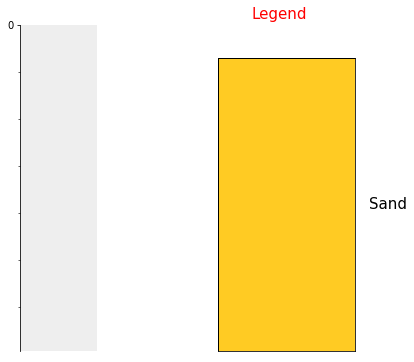

In [21]:
p.boreholes_3d[0].log_plot()

### The Borehole in 3D using X3D for interaction within the notebook

In [22]:
p.plot3d(x3d=True)